In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from math import exp, log, cos, cosh, sqrt, sinh, pi
from time import process_time

In [ ]:
from scipy.integrate import quad

In [ ]:
@jit
def f(t_rn, h, T, nj):
    return exp(-h*cos(2*pi*t_rn/T)*nj)

@jit 
def g(t_rn, J, h, T, ni, nj):
    return exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)

In [ ]:
J = 4
h = 0.2
T = 10
ni = -1
nj = 1

In [ ]:
ts = np.linspace(0, T, num = 2001)
signals_1 = np.zeros(2001)
signals_2 = np.zeros(2001)
signals_3 = np.zeros(2001)
signals_4 = np.zeros(2001)
integrated_signals= np.zeros(2001)

for i in range(2001):
    signals_1[i] = g(ts[i], J, h, T, 1, 1)
    signals_2[i] = g(ts[i], J, h, T, 1, -1)
    signals_3[i] = g(ts[i], J, h, T, -1, 1)
    signals_4[i] = g(ts[i], J, h, T, -1, -1)
    
    #integrated_signals[i] = quad(g, 0, ts[i], args=(J, h, T, ni, nj))[0]
    
plt.scatter(ts, signals_1)
plt.scatter(ts, signals_2)
plt.scatter(ts, signals_3)
plt.scatter(ts, signals_4)
plt.legend(['1, 1', '1, -1', '-1, 1', '-1, -1'])
#plt.scatter(ts, integrated_signals)

In [ ]:
ts = np.linspace(0, T, num = 1001)
signals_1 = np.zeros(1001)
signals_2 = np.zeros(1001)
signals_3 = np.zeros(1001)
signals_4 = np.zeros(1001)
integrated_signals= np.zeros(1001)

for i in range(1001):
    signals_1[i] = g(ts[i], J, -0.2, T, 1, 1)
    signals_2[i] = g(ts[i], J, -0.2, T, 1, -1)
    signals_3[i] = g(ts[i], J, -0.2, T, -1, 1)
    signals_4[i] = g(ts[i], J, -0.2, T, -1, -1)
    
    #integrated_signals[i] = quad(g, 0, ts[i], args=(J, h, T, ni, nj))[0]
    
plt.scatter(ts, signals_1)
plt.scatter(ts, signals_2)
plt.scatter(ts, signals_3)
plt.scatter(ts, signals_4)
plt.legend(['1, 1', '1, -1', '-1, 1', '-1, -1'])
#plt.scatter(ts, integrated_signals)

In [ ]:
int_1 = quad(f, 14.91, 15, args=(h, T, nj))[0] 
int_2 = quad(f, 14.91, 14.92, args=(h, T, nj))[0] 

print(int_2-int_1, np.abs(int_2-int_1)/int_2)

In [2]:
@jit(nopython=True)
def TD_1DChain(T, dmu, h, initial_chain=np.random.choice([-1,1], size=1000),
               P_gen_kj=np.ones((2,2))*0.5, J=4,
               Periods = 50, t_intervals = None, track_size = 10000):
    '''
    Time-dependent rejection-based SSA (tRSSA)
    
    Parameters
    ----------
    T: Period of the external cosine signal 
    dmu: The additional chemical potential from equilbirum 
    h:strength of the external signal
    
    P_gen_kj:  the probability of getting a particular particle nk from the bath given the interface particle is nj
       -1   1    
    -1 0.5 0.5
     1 0.5 0.5
    in general it is a matrix as above. Here just 0.5
    
    J: monomer-monomer interaction strength
    
    initial_chain_size: size for the initial bulk
    
    
    Periods: number of periods to simulate 
    
    there are 6 reactions
    1: -1 -> -1 1
    2: -1 -> -1 -1
    3: -1 -> 
    4: 1 -> 1 1
    5: 1 -> 1 -1
    6: 1 -> 
    
    Returns
    -------
    Timestamps and Changes of 1D-Chain
    '''     

    #Track the change of the 1D-Chain
    Chain_Changes = np.zeros(track_size)
    cc_i = 1000
    
    #track chain configuration
    initial_chain[-1] = -1
    initial_chain[-2] = 1
    chain = np.zeros(track_size)
    chain[0:1000] = initial_chain
    chain_length= len(chain)
    c_i = 1000
    
    #outmost blocks
    nj = initial_chain[-1]
    ni = initial_chain[-2]
    
    #track time
    reaction_time = np.zeros(track_size)
    rt_i = 0
    
    t_max = T*Periods
    #print(t_max)
    t_rn = 0
    t_next = t_intervals[1]
    dt = ts[1]

    #track time
    i = 1
        
    #print(t_intervals)    
    #print(t_next)
    
    #calculate chemical potential and rate constant for adding a spin
    mu_eq0 = log(2/(exp(J)*(cosh(h)+sqrt(exp(-4*J)+sinh(h)**2))))
    mu = mu_eq0+dmu
    exp_mu = exp(mu)
    
    #compute the time homogeneous rate for addition
    additon_a_matrix = exp_mu*P_gen_kj
    
    #bound for h is always 1, bound propoensity is same for rate fuction
    a_lb = np.zeros(6)
    a_ub = np.zeros(6)
    #add 1 to -1
    a1 = additon_a_matrix[0,1]
    a_lb[0] = a1
    a_ub[0] = a1
    #add -1 to -1
    a2 = additon_a_matrix[0,0]
    a_lb[1] = a2
    a_ub[1] = a2
    #removal of -1
    #if h is positive, initial signal for boundary = 1 -1 is decreasing
    if h > 0:
        a_lb[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
        a_ub[2] = exp(-J*ni*nj-h*np.cos(2*pi*0/T)*nj)
    else:
        a_lb[2] = exp(-J*ni*nj-h*np.cos(2*pi*0/T)*nj) 
        a_ub[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
    a0_ub = np.sum(a_ub)
    
    
    while t_rn < t_max:
        
        #print(a_ub)
        
        tau = -1/a0_ub*log(np.random.random())
        t_rn = t_rn+tau
        #print(t_rn, t_next)
       
        
        if t_rn > t_next:
            t_rn = t_next
            i = i+1
            t_next = ts[i]
            
            #check if the signal is in first or second half
            first_half_T = True
            if np.floor(t_rn/(T/2))%2 == 1:
                first_half_T = False
            
            nj = chain[-1]
            ni = chain[-2]
            
            #update propensity bounds
            a_lb = np.zeros(6)
            a_ub = np.zeros(6)
            
            if nj == -1:
                #add 1 to -1
                a1 = additon_a_matrix[0,1]
                a_lb[0] = a1
                a_ub[0] = a1
                #add -1 to -1
                a2 = additon_a_matrix[0,0]
                a_lb[1] = a2
                a_ub[1] = a2
            else:
                #add 1 to 1
                a4 = additon_a_matrix[1,1]
                a_lb[3] = a4
                a_ub[3] = a4
                #add -1 to 1
                a5 = additon_a_matrix[1,0]
                a_lb[4] = a5
                a_ub[4] = a5
            
            if h > 0:
                if nj == -1:
                    #decresing signal for removal 
                    if first_half_T:
                        a_lb[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
                        a_ub[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
                    #incresing signal
                    else:
                        a_lb[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
                        a_ub[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
                else:
                    #increasing signal for removal
                    if first_half_T:
                        a_lb[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
                        a_ub[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
                    #decreasing signal for removal
                    else:
                        a_lb[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
                        a_ub[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
            else:
                if nj == -1:
                    #inscreasing signal for removal 
                    if first_half_T:
                        a_lb[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj) 
                        a_ub[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
                    #incresing signal
                    else:
                        a_lb[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
                        a_ub[2] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
                else:
                    #decreasing signal for removal
                    if first_half_T:
                        a_lb[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj) 
                        a_ub[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
                    #decreasing signal for removal
                    else:
                        a_lb[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
                        a_ub[5] = exp(-J*ni*nj-h*np.cos(2*pi*t_next/T)*nj)
            continue;
        
        
        #compare propensity to choose a reaction
        aj_ub_sums = np.zeros(6)
        aj_ub_sums[0] = a_ub[0]
        for j in range(1, 6):
            aj_ub_sums[j] = aj_ub_sums[j-1]+a_ub[j]
        r2 = np.random.random()
        r2a0_ub = r2*aj_ub_sums[-1]
        arg = 0
        for j in range(6):
            if aj_ub_sums[j] > r2a0_ub:
                arg = j
                break;
        
        #check if the reaction should occur
        Accept = False
        r3 = np.random.random()   
        if r3 <= (np.sum(a_lb)/np.sum(a_ub)):
            Accept = True
        else:
            #evaluate propensity of current state
            a0 = 0
            if nj == -1:
                a0 = additon_a_matrix[0,1]+additon_a_matrix[0,0]+exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
            else:
                a0 = additon_a_matrix[1,1]+additon_a_matrix[1,0]+exp(-J*ni*nj-h*np.cos(2*pi*t_rn/T)*nj)
            if r3 <= (a0/np.sum(a_ub)):
                Accept = True
        
        if Accept:      
            #choose a reaction
            #add +1
            if arg == 0 or arg == 3:
                chain_length += 1
                ni = nj
                nj = 1
                Chain_Changes[cc_i] = 1 
                chain[c_i] = 1
                c_i += 1
                cc_i += 1
                
                
            #add -1
            elif arg == 1 or arg == 4:
                chain_length += 1
                ni = nj
                nj = -1
                Chain_Changes[cc_i] = -1 
                chain[c_i] = -1
                c_i += 1
                cc_i += 1
            #removal
            else:
                chain_length -= 1
                c_i -= 1
                nj = chain[c_i]
                ni = chain[c_i-1]
                Chain_Changes[cc_i] = 2 
                cc_i += 1
                
            reaction_time[rt_i] = t_rn
            rt_i += 1
            
            if Chain_Changes[-1] != 0:
                Chain_Changes[0:1000] = Chain_Changes[-1000:]
                Chain_Changes[1000:] = np.zeros(track_size-1000)
                cc_i = 1000
            if reaction_time[-1] > 0:
                reaction_time[0:1000] = reaction_time[-1000:]
                reaction_time[1000:] = np.zeros(track_size-1000)
                rt_i = 1000
            if chain[-1] != 0:
                chain[0:1000] = chain[-1000:]
                chain[1000:] = np.zeros(track_size-1000)
                #print(t_rn, chain_length)
                c_i = 1000
            
            
    return chain_length, chain, Chain_Changes, reaction_time

In [3]:
#initial_chain = np.random.choice([-1,1], size=10000)

T = 1000
J = 4
h = 0.2
dmu = 5
Periods = 50

ts = np.linspace(0, T*Periods, num=T*Periods*10+1)

t_start = process_time() 
chain_length, chain, Chain_Changes, reaction_time = TD_1DChain(T, dmu, h, Periods = Periods, t_intervals=ts)
t_end = process_time() 
print(t_end-t_start)

print(chain_length)

2.671875
150968


In [ ]:
trials = 50
simulation_time = np.zeros(trials)
for i in range(trials):
    t_start = process_time() 
    chain_length, chain, Chain_Changes, reaction_time = TD_1DChain(T, dmu, h, Periods = Periods, t_intervals=ts)
    t_end = process_time() 
    print(t_end-t_start)
    print(chain_length)
    simulation_time[i] = t_end-t_start

In [7]:
print(np.mean(simulation_time))

0.183125


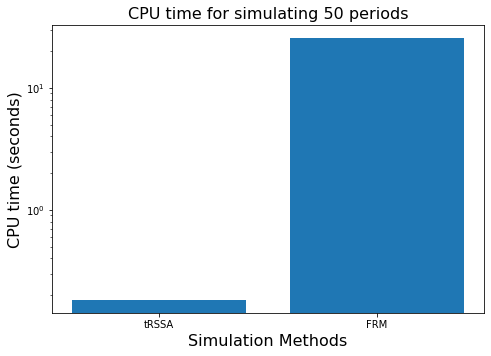

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yscale('log')
methods = ['tRSSA', 'FRM']
speeds = [np.mean(simulation_time),25.7]
ax.bar(methods,speeds)
ax.set_ylabel('CPU time (seconds)', fontsize=16)
ax.set_xlabel('Simulation Methods', fontsize=16)
ax.set_title('CPU time for simulating 50 periods', fontsize=16)
fig.savefig('CPUtime_vs_methods.png', dpi=200)



In [ ]:
print(reaction_time[0:20])

In [ ]:
#trim the 0s
chain = np.trim_zeros(chain, 'b')
Chain_Changes = np.trim_zeros(Chain_Changes, 'b')
reaction_time = np.trim_zeros(reaction_time, 'b')

In [ ]:
trials = 9000
for trial_i in range(trials):
    chain_length, chain, Chain_Changes, reaction_time = TD_1DChain(T, dmu, h, 
                                                               Periods = Periods, t_intervals=ts)
    chain = np.trim_zeros(chain, 'b')
    Chain_Changes = np.trim_zeros(Chain_Changes, 'b')
    reaction_time = np.trim_zeros(reaction_time, 'b')
    
    print(chain_length)
    
    vals_to_save = {'chain_length':chain_length,
                    'chain': chain, 'Chain_Changes':Chain_Changes, 'reaction_time': reaction_time}
    save_str = 'data/T='+str(T)+'_h='+str(h)+'_'+str(trial_i+1000)
    np.savez(save_str, **vals_to_save)

In [ ]:
def bits_patterns(n):
    '''
    Generate all patterns of 1&-1's of size n
    '''
    ps = ['-1', '1']
    for i in range(n-1):
        ps_temp = []
        for i in range(len(ps)):
            ps_temp.append(ps[i]+'-1')
            ps_temp.append(ps[i]+'1')
        ps = ps_temp
    return ps  

In [ ]:
def bits_pattern_dict(n):
    two_to_n = 2**n
    n_bits_patterns = bits_patterns(n)
    #create a dictionary to store patterns index
    n_bits_patterns_dict = {}
    for i in range(two_to_n):
        n_bits_patterns_dict[n_bits_patterns[i]] = i
    return n_bits_patterns_dict

In [ ]:
n_trials = 10000
n_sample_interval = 1000
n_samples = int(n_trials/n_sample_interval)
n_sites = 10
num_patterns = 2**n_sites

In [ ]:
n_bits_ps_dict = bits_pattern_dict(n_sites)
#store the running frequencies
n_bits_ps_freq = np.zeros( len(n_bits_ps_dict) ) 

In [ ]:
#save the distributions for n_samples
n_bits_ps_dist = []
#analyze distributions
for i in range(n_trials):
    data = np.load('data/T='+str(T)+'_h='+str(h)+'_'+str(i)+'.npz')
    last_n_sites = "".join(map(str, data['chain'][-n_sites:].astype(int))) 
    n_bits_ps_freq[n_bits_ps_dict[last_n_sites]] += 1
    if i > 0 and (i+1)%n_sample_interval==0:
        n_bits_ps_dist.append(n_bits_ps_freq/i)

n_bits_ps_dist = np.array(n_bits_ps_dist)
    

In [ ]:
x_array = np.arange(num_patterns)
for i in range(n_samples):
    plt.scatter(x_array, n_bits_ps_dist[i], s=1)
    plt.legend([str(n_sample_interval*(i+1))])
    plt.ylim(0, 0.0025)
    save_str = '10sites_dist_samples='+ str(n_sample_interval*(i+1)) +'.png'
    plt.ylabel('Probability', size=16)
    plt.xlabel('Pattern Labels', size=16)
    plt.title('10 Sites Pattern Distributions', size=16)
    plt.savefig(save_str, dpi=200)
    plt.show()
#plt.legend(['1000', '2000', '3000', '4000', '5000', '6000', '7000', '8000', '9000'])

In [ ]:
from scipy.special import kl_div

In [ ]:
kl_div_to_final = np.zeros(n_samples)
for i in range(n_samples-1):
    kl_div_to_final[i] = np.sum(kl_div(n_bits_ps_dist[i], n_bits_ps_dist[n_samples-1]))

In [ ]:
n_samples_array = (np.arange(n_samples)+1)*n_sample_interval
plt.scatter(n_samples_array[:-1], kl_div_to_final[:-1])
plt.title('KL Divergence to Final Distributions of 10 sites')
plt.xlabel('Number of Samples', size=16)
plt.savefig('10sites_KLDIV_vs_samples.png', dpi=200)

In [ ]:
print( kl_div_to_final)